# Gradient Domain Fusion

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy as sc
import scipy.sparse.linalg

from cv2 import pyrDown, pyrUp

import utils
from utils import *

## Part 1 Toy Problem (20 pts)

In [2]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    
    # TO DO
    
    img_h, img_w = img.shape
    im2var = np.arange(img_h * img_w).reshape(img_h, img_w)
    v_dimension = (img_h) * (img_w)
    
    # initialize A sparse matrix and b
    A = scipy.sparse.lil_matrix(((img_h * (img_w)) + ((img_h)*img_w) + 1,img_w * img_h), dtype = np.float) 
    b = np.zeros(v_dimension * 2 + 1)
    
    
    # Initialize A and b values
    e = 0
    A[e][0] = 1
    b[e] = img[0][0]
    e += 1
    
    # loop thorugh source image
    for y in range(0, img_h):
        for x in range(0, img_w):
            
            # Objective 1 v(x+1,y)-v(x,y)
            if x < img_w - 1:
                A[e, im2var[y][x+1]] = 1
                A[e, im2var[y][x]] = -1
                b[e] = img[y][x+1] - img[y][x]
                e += 1
            else:
                A[e, im2var[y][x]] = -1
                b[e] = -img[y][x]
                e += 1

            # Objective 2 v(x,y+1)-v(x,y)
            if y < img_h - 1:
                A[e, im2var[y+1][x]] = 1
                A[e, im2var[y][x]] = -1
                b[e] = img[y+1][x] - img[y][x]
                e += 1
            else:
                A[e, im2var[y][x]] = -1
                b[e] = -1*img[y][x]
                e += 1
            
    
    print("Converting to Sparse Matrix")
    sA = scipy.sparse.csr_matrix(A) 
    print("Finding Least Square solution")
    v = scipy.sparse.linalg.lsqr(sA, b)[0].reshape(img_h, img_w);
    return v



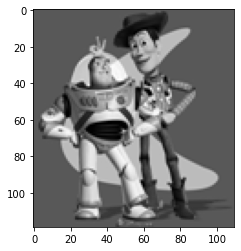

Converting to Sparse Matrix
Finding Least Square solution


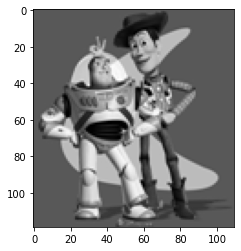

Max error is:  9.271860823556466e-08


In [3]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

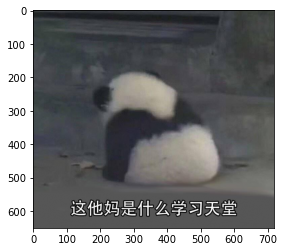

In [12]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/panda.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(object_img)
plt.show()

use_interface = True  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2500) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


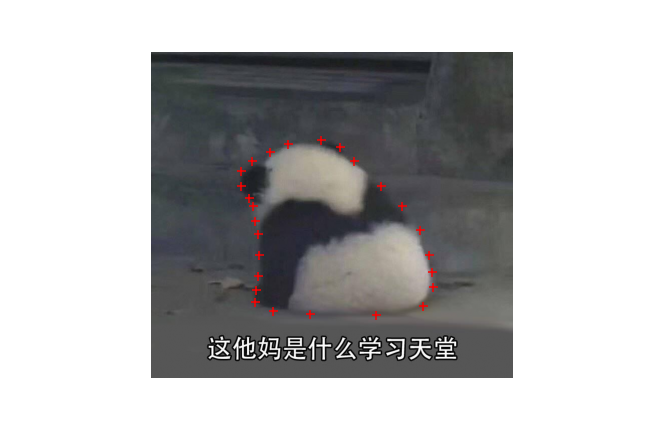

In [13]:
if use_interface:
    import matplotlib.pyplot as plt
    %matplotlib notebook
    mask_coords = specify_mask(object_img)

In [14]:
if use_interface:
    xs = mask_coords[0]
    ys = mask_coords[1]
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure()
    object_mask = get_mask(ys, xs, object_img)

<Figure size 432x288 with 0 Axes>

In [15]:
# %matplotlib notebook
# import matplotlib.pyplot as plt
# bottom_center = specify_bottom_center(background_img)
# bottom_center = (400, 600) # (x,y)

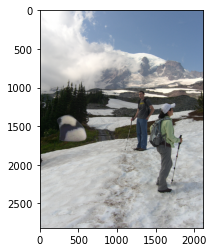

In [18]:
if use_interface:
#     %matplotlib notebook
#     import matplotlib.pyplot as plt
#     bottom_center = specify_bottom_center(background_img)
#     %matplotlib inline
#     import matplotlib.pyplot as plt
    
    bottom_center = (400, 1700) # (x,y)
    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



## Part 2 Poisson Blending (50 pts)

In [19]:
def gradient_domain2(objectImage, mask, backgroundImage):
    
    # TO DO
    img_h, img_w = objectImage.shape
    img_h = img_h
    img_w = img_w
    im2var = np.arange((img_h) * (img_w)).reshape(img_h, img_w)
    v_dimension = (img_h) * (img_w)
    
    # initialize A sparse matrix and b
    A = scipy.sparse.lil_matrix((v_dimension * 4, img_w * img_h), dtype = np.float)
                                
    b = np.zeros(v_dimension * 4)
    
    # Initialize A and b values
    e = 0
    
    # loop thorugh source image
    for y in range(0, img_h):
        for x in range(0, img_w):
            varX = x - 1
            varY = y - 1
            if mask[y, x] == 1:
                if x == 0 or y == 0 or x + 2 >= img_w or y+2 >= img_h:
                    A[e, im2var[varY][varX]] = 1
                    b[e] = backgroundImage[y][x]
                    e += 1
                # v(x+1, y+1) - v(x, y) = s(x, y+1) - s(x, y)
                if x + 1 < img_w:
                    A[e, im2var[varY][varX+1]] = 1
                    A[e, im2var[varY][varX]] = -1
                    b[e] = objectImage[y][x+1] - objectImage[y][x]
                    e += 1
                # v(x, y) - t(x+1, y) = s(x, y) - s(x+1, y)

                # v(x, y+1) - v(x, y) = s(x, y+1) - s(x, y)
                if y + 1 < img_h:
                    A[e, im2var[varY+1][varX]] = 1
                    A[e, im2var[varY][varX]] = -1
                    b[e] = objectImage[y+1][x] - objectImage[y][x]
                    e += 1

                # most left
                # v(x, y) - t(x-1, y) = s(x, y) - s(x-1, y)
                if x > 0:
                    A[e, im2var[varY][varX-1]] = 1
                    A[e, im2var[varY][varX]] = -1
                    b[e] = objectImage[y][x-1] - objectImage[y][x]
                    e += 1

                # top
                # v(x, y) - t(x, y-1) = s(x, y) - s(x, y-1)
                if y > 0:
                    A[e, im2var[varY-1][varX]] = 1
                    A[e, im2var[varY][varX]] = -1
                    b[e] = objectImage[y-1][x] - objectImage[y][x]
                    e += 1
            else:
                A[e, im2var[varY][varX]] = 1
                b[e] = backgroundImage[y][x]
                e += 1
            
    # Here, "e" is used as an equation counter. Note that the y-coordinate is the first index. As another example, objective 3 above can be written as:
    print("Finding the sparse matrix!")
    sA = scipy.sparse.csr_matrix(A) 
    print("Finding Least Square solution")
    v = scipy.sparse.linalg.lsqr(sA, b)[0].reshape(img_h, img_w);
    return v


In [20]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    
    
    """
    
    #TO DO 
    # find the top of the source
    
    startingRow = bg_ul[0]
    # find the end 
    endRow = startingRow + object_img.shape[0]
    
    # find the left of the source
    startingCol = bg_ul[1] 
    endCol = startingCol + object_img.shape[1]
    
    backgroundImage = bg_img[startingRow:endRow+1, startingCol:endCol+1]
    
    img = gradient_domain2(object_img, object_mask, backgroundImage)
    bg_img[startingRow:endRow, startingCol:endCol] = img
    return bg_img



Finding the sparse matrix!
Finding Least Square solution
Finding the sparse matrix!
Finding Least Square solution
Finding the sparse matrix!
Finding Least Square solution


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


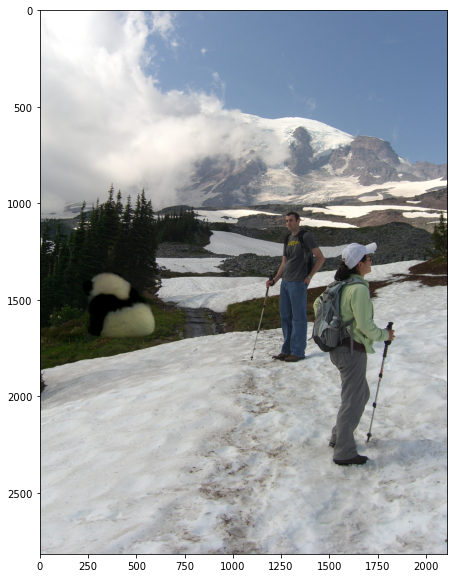

In [21]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
    im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(10,10))
plt.imshow(im_blend)

### Direct pasting

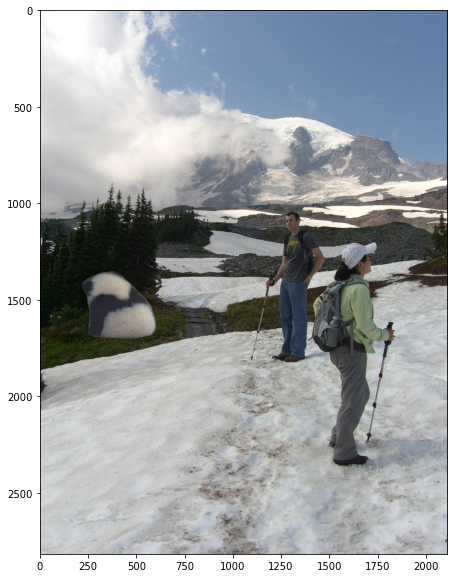

In [22]:
combined = utils.get_combined_img(background_img, object_img, object_mask, bg_ul)
plt.figure("Straight Combined", figsize=(10, 10))
plt.imshow(combined)

## Part 3 Mixed Gradients (20 pts)

In [23]:
def gradient_domain3(objectImage, mask, backgroundImage):
    
    # TO DO
    img_h, img_w = objectImage.shape
    img_h = img_h
    img_w = img_w
    im2var = np.arange((img_h) * (img_w)).reshape(img_h, img_w)
    v_dimension = (img_h) * (img_w)
    
    # initialize A sparse matrix and b
    A = scipy.sparse.lil_matrix((v_dimension * 4, img_w * img_h), dtype = np.float)
                                
    b = np.zeros(v_dimension * 4)
    
    # Initialize A and b values
    e = 0
    
    # loop thorugh source image
    for y in range(0, img_h):
        for x in range(0, img_w):
            varX = x - 1
            varY = y - 1
            if mask[y, x] == 1:
                if x == 0 or y == 0 or x + 1 >= img_w or y+1 >= img_h:
                    A[e, im2var[varY][varX]] = 1
                    b[e] = backgroundImage[y][x]
                    e += 1
                    
                # v(x+1, y+1) - v(x, y) = s(x, y+1) - s(x, y)
                if x + 1 < img_w:
                    A[e, im2var[varY][varX+1]] = 1
                    A[e, im2var[varY][varX]] = -1
                    
                    if abs(objectImage[y][x+1] - objectImage[y][x]) > abs(backgroundImage[y][x+1] - backgroundImage[y][x]):
                        b[e] = objectImage[y][x+1] - objectImage[y][x]
                    else:
                        b[e] = backgroundImage[y][x+1] - backgroundImage[y][x]
                        
                    e += 1
                    
                # v(x, y+1) - v(x, y) = s(x, y+1) - s(x, y)
                if y + 1 < img_h:
                    A[e, im2var[varY+1][varX]] = 1
                    A[e, im2var[varY][varX]] = -1
                    
                    if abs(objectImage[y+1][x] - objectImage[y][x]) > abs(backgroundImage[y+1][x] - backgroundImage[y][x]):
                        b[e] = objectImage[y+1][x] - objectImage[y][x]
                    else:
                        b[e] = backgroundImage[y+1][x] - backgroundImage[y][x]
                        
                    e += 1

                # most left
                # v(x, y) - t(x-1, y) = s(x, y) - s(x-1, y)
                if x > 0:
                    A[e, im2var[varY][varX-1]] = 1
                    A[e, im2var[varY][varX]] = -1
                    if abs(objectImage[y][x-1] - objectImage[y][x]) > abs(backgroundImage[y][x-1] - backgroundImage[y][x]):
                        b[e] = objectImage[y][x-1] - objectImage[y][x]
                    else:
                        b[e] = backgroundImage[y][x-1] - backgroundImage[y][x]
                        
                    e += 1

                # top
                # v(x, y) - t(x, y-1) = s(x, y) - s(x, y-1)
                if y > 0:
                    A[e, im2var[varY-1][varX]] = 1
                    A[e, im2var[varY][varX]] = -1
                    
                    if abs(objectImage[y-1][x] - objectImage[y][x]) > abs(backgroundImage[y-1][x] - backgroundImage[y][x]):
                        b[e] = objectImage[y-1][x] - objectImage[y][x]
                    else:
                        b[e] = backgroundImage[y-1][x] - backgroundImage[y][x]
                        
                    b[e] = objectImage[y-1][x] - objectImage[y][x]
                    e += 1
            else:
                A[e, im2var[varY][varX]] = 1
                b[e] = backgroundImage[y][x]
                e += 1
            
    # Here, "e" is used as an equation counter. Note that the y-coordinate is the first index. As another example, objective 3 above can be written as:
    print("Finding the sparse matrix!")
    sA = scipy.sparse.csr_matrix(A) 
    print("Finding Least Square solution")
    v = scipy.sparse.linalg.lsqr(sA, b)[0].reshape(img_h, img_w);
    return v



In [24]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 
    
    startingRow = bg_ul[0]
    # find the end 
    endRow = startingRow + object_img.shape[0]
    
    # find the left of the source
    startingCol = bg_ul[1] 
    endCol = startingCol + object_img.shape[1]
    
    backgroundImage = bg_img[startingRow:endRow+1, startingCol:endCol+1]
    
    img = gradient_domain3(object_img, object_mask, backgroundImage)
    bg_img[startingRow:endRow, startingCol:endCol] = img
    return bg_img



Finding the sparse matrix!
Finding Least Square solution
Finding the sparse matrix!
Finding Least Square solution
Finding the sparse matrix!
Finding Least Square solution


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


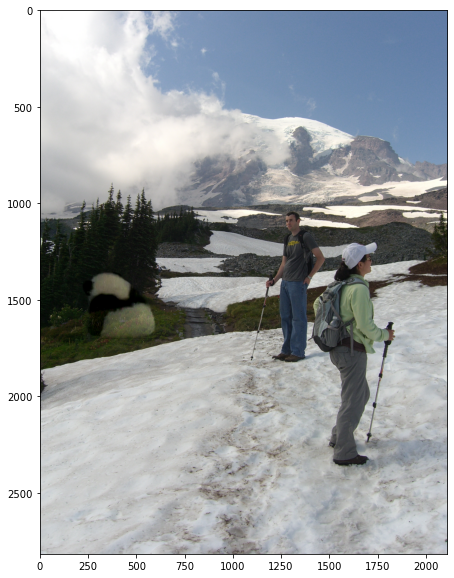

In [25]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(10,10))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [7]:
def color2gray(objectImage):
    
    # TO DO
    img_h, img_w = objectImage[:,:,0].shape
    
    r_l = objectImage[:,:,0]
    g_l = objectImage[:,:,1]
    b_l = objectImage[:,:,2]
    
    img_h = img_h
    img_w = img_w
    im2var = np.arange((img_h) * (img_w)).reshape(img_h, img_w)
    v_dimension = (img_h) * (img_w)
    
    # initialize A sparse matrix and b
    A = scipy.sparse.lil_matrix((v_dimension * 4, img_w * img_h), dtype = np.float)
                                
    b = np.zeros(v_dimension * 4)
    
    # Initialize A and b values
    e = 0
    
    # loop thorugh source image
    for y in range(0, img_h):
        for x in range(0, img_w):
            varX = x - 1
            varY = y - 1
            # v(x+1, y+1) - v(x, y) = s(x, y+1) - s(x, y)
            if x + 1 < img_w:
                A[e, im2var[varY][varX+1]] = 1
                A[e, im2var[varY][varX]] = -1

                val = np.array([
                    (r_l[y][x+1] - r_l[y][x]),
                    (g_l[y][x+1] - g_l[y][x]),
                    (b_l[y][x+1] - b_l[y][x])
                ])

                maxInd = np.argmax(np.abs(val))
                b[e] = val[maxInd]
                e += 1

            # v(x, y+1) - v(x, y) = s(x, y+1) - s(x, y)
            if y + 1 < img_h:
                A[e, im2var[varY+1][varX]] = 1
                A[e, im2var[varY][varX]] = -1

                val = np.array([
                    (r_l[y+1][x] - r_l[y][x]),
                    (g_l[y+1][x] - g_l[y][x]),
                    (b_l[y+1][x] - b_l[y][x]),
                ])

                maxInd = np.argmax(np.abs(val))

                b[e] = val[maxInd]

                e += 1

            # most left
            # v(x, y) - t(x-1, y) = s(x, y) - s(x-1, y)
            if x > 0:
                A[e, im2var[varY][varX-1]] = 1
                A[e, im2var[varY][varX]] = -1

                val = np.array([
                    (r_l[y][x-1] - r_l[y][x]),
                    (g_l[y][x-1] - g_l[y][x]),
                    (b_l[y][x-1] - b_l[y][x])
                ])

                maxInd = np.argmax(np.abs(val))

                b[e] = val[maxInd]


                e += 1

            # top
            # v(x, y) - t(x, y-1) = s(x, y) - s(x, y-1)
            if y > 0:
                A[e, im2var[varY-1][varX]] = 1
                A[e, im2var[varY][varX]] = -1

                val = np.array([
                    (r_l[y-1][x] - r_l[y][x]),
                    (g_l[y-1][x] - g_l[y][x]),
                    (b_l[y-1][x] - b_l[y][x]),
                ])

                maxInd = np.argmax(np.abs(val))

                b[e] = val[maxInd]

                e += 1
            
    # Here, "e" is used as an equation counter. Note that the y-coordinate is the first index. As another example, objective 3 above can be written as:
    print("Finding the sparse matrix!")
    sA = scipy.sparse.csr_matrix(A) 
    print("Finding Least Square solution")
    v = scipy.sparse.linalg.lsqr(sA, b)[0].reshape(img_h, img_w);
    return v



<IPython.core.display.Javascript object>


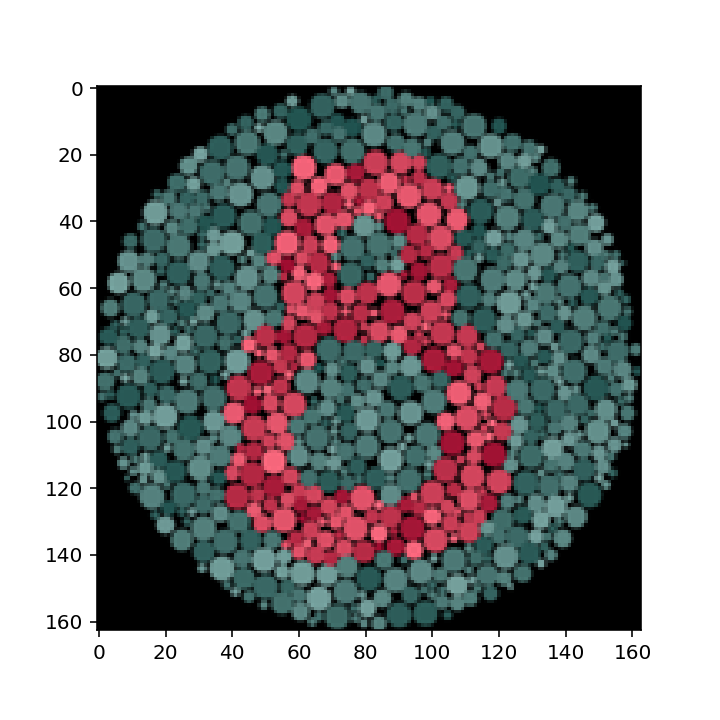

Finding the sparse matrix!
Finding Least Square solution


<IPython.core.display.Javascript object>


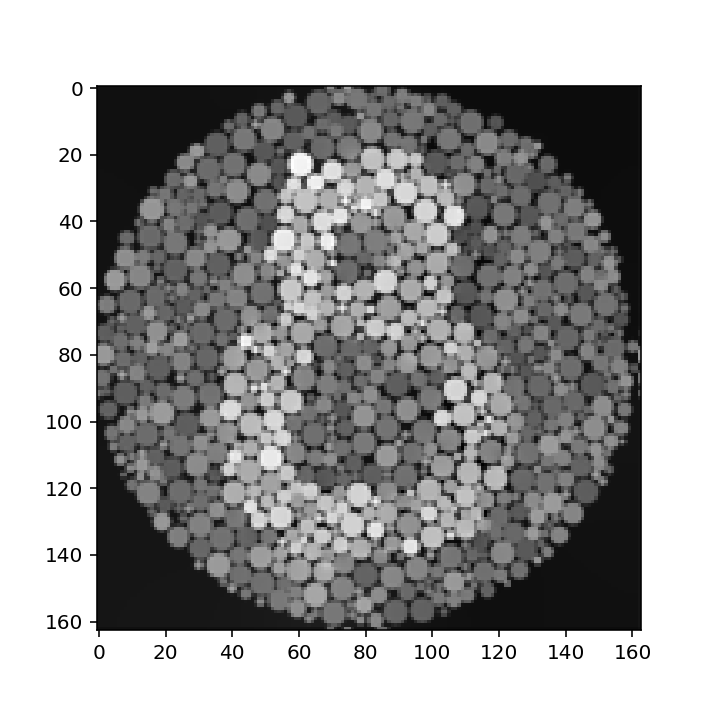

<IPython.core.display.Javascript object>


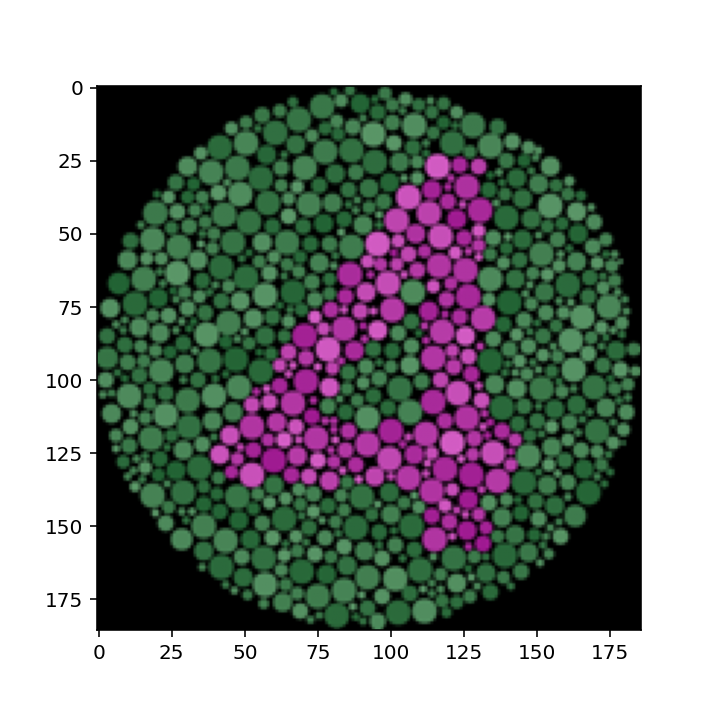

Finding the sparse matrix!
Finding Least Square solution


<IPython.core.display.Javascript object>


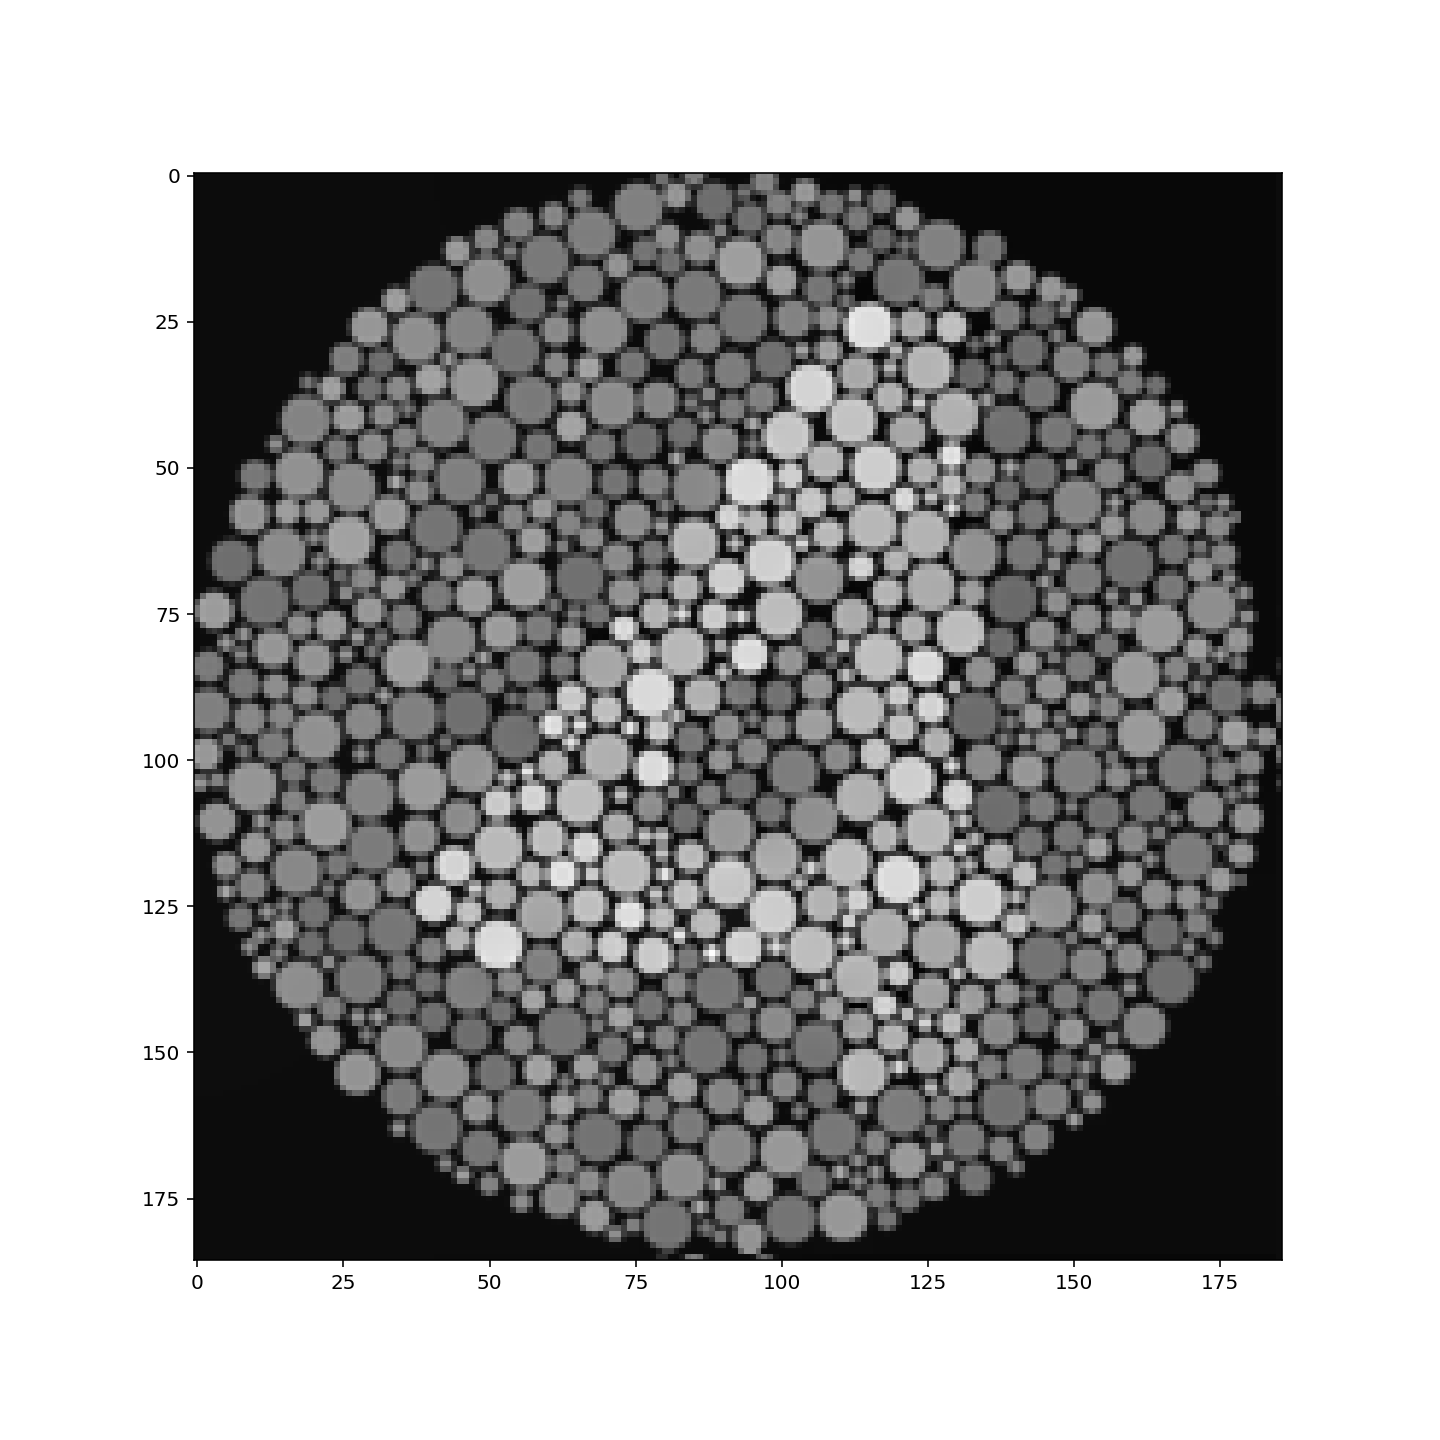

In [31]:
colorImg = cv2.cvtColor(cv2.imread('samples/colorBlind8.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure("Colored 8", figsize=(5, 5))
plt.imshow(colorImg)
plt.show()
gray_eight = color2gray(colorImg)
plt.figure("Grayscale 8", figsize=(5, 5))
plt.imshow(gray_eight, cmap = "gray")
plt.show()

colorImg = cv2.cvtColor(cv2.imread('samples/colorBlind4.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure("Colored 4", figsize=(5, 5))
plt.imshow(colorImg)
plt.show()
gray_four = color2gray(colorImg)
plt.figure("Grayscale 4", figsize=(5, 5))
plt.imshow(gray_four, cmap = "gray")
plt.show()

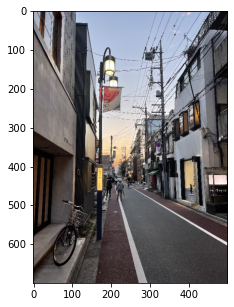

Finding the sparse matrix!
Finding Least Square solution


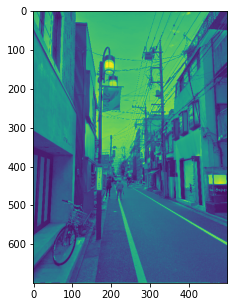

In [10]:
natural_img = cv2.cvtColor(cv2.imread('samples/street.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
natural_img = cv2.resize(natural_img, (500, 700))
plt.figure("Nature street", figsize=(5, 5))
plt.imshow(natural_img)
plt.show()

gray_nature = color2gray(natural_img)

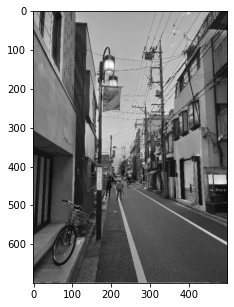

In [11]:
plt.figure("Gray street", figsize=(5, 5))
plt.imshow(gray_nature, cmap="gray")
plt.show()

## Laplacian pyramid blending (20 pts)

In [26]:
def blur_downsample(img):
    im = cv2.GaussianBlur(img, (25, 25), 3)
    return cv2.pyrDown(im)
    

In [27]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
    
    startingRow = bg_ul[0]
    # find the end 
    endRow = startingRow + object_img.shape[0]
    
    # find the left of the source
    startingCol = bg_ul[1] 
    endCol = startingCol + object_img.shape[1]
    
    backgroundImage = bg_img[startingRow:endRow, startingCol:endCol]
    
    bg_mask = 1 - object_mask
    
    gpyr = []
    
    
    # First pyramid
    object_g0 = object_img
    bg_g0 = backgroundImage
    obj_mask_g0 = object_mask
    bg_mask_g0 = bg_mask
    
    object_g1 = blur_downsample(object_g0)
    bg_g1 = blur_downsample(bg_g0)
    
    
    size = (object_g0.shape[1], object_g0.shape[0])
    object_l0 = object_g0 - pyrUp(object_g1, dstsize=size)
    size = (bg_g0.shape[1], bg_g0.shape[0])
    
    bg_l0 = bg_g0 - pyrUp(bg_g1, dstsize=size)
    

    gypr_0 = object_l0*obj_mask_g0 + bg_l0*bg_mask_g0
    
    
    # Second pyramid
    obj_mask_g1 = blur_downsample(obj_mask_g0)
    bg_mask_g1 = blur_downsample(bg_mask_g0)
    
    object_g2 = blur_downsample(object_g1)
    bg_g2 = blur_downsample(bg_g1)
    
    
    size = (object_g1.shape[1], object_g1.shape[0])
    object_l1 = object_g1 - pyrUp(object_g2, dstsize = size)
    
    size = (bg_g1.shape[1], bg_g1.shape[0])
    bg_l1 = bg_g1 - pyrUp(bg_g2, dstsize=size)
    
    gypr_1 = object_l1*obj_mask_g1 + bg_l1*bg_mask_g1
    
    # Third pyramid
    obj_mask_g2 = blur_downsample(obj_mask_g1)
    bg_mask_g2 = blur_downsample(bg_mask_g1)
    
    object_g3 = blur_downsample(object_g2)
    bg_g3 = blur_downsample(bg_g2)
    
    
    size = (object_g2.shape[1], object_g2.shape[0])
    object_l2 = object_g2 - pyrUp(object_g3, dstsize=size)
    size = (bg_g2.shape[1], bg_g2.shape[0])
    bg_l2 = bg_g2 - pyrUp(bg_g3, dstsize=size)
    
    gypr_2 = object_l2*obj_mask_g2 + bg_l2*bg_mask_g2
    
    # Upsample and add
    
    
    size = (object_g2.shape[1], object_g2.shape[0])
    obj_upsample2 = pyrUp(object_g3, dstsize=size)
    size = (bg_g2.shape[1], bg_g2.shape[0])
    bg_upsample2 = pyrUp(bg_g3, dstsize=size)
    
    final_0 = gypr_2 + obj_upsample2*obj_mask_g2 + bg_upsample2*bg_mask_g2
    
    size = (gypr_1.shape[1], gypr_1.shape[0])
    final_1 = pyrUp(final_0, dstsize=size) + gypr_1
    
    size = (gypr_0.shape[1], gypr_0.shape[0])
    final = pyrUp(final_1, dstsize=size) + gypr_0
    
    
    bg_img[startingRow:endRow, startingCol:endCol] = final
    
    return bg_img

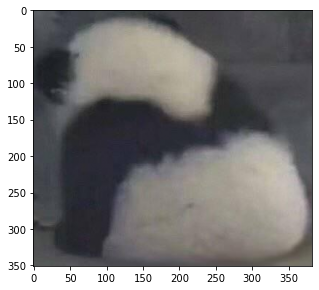

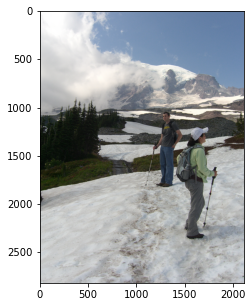

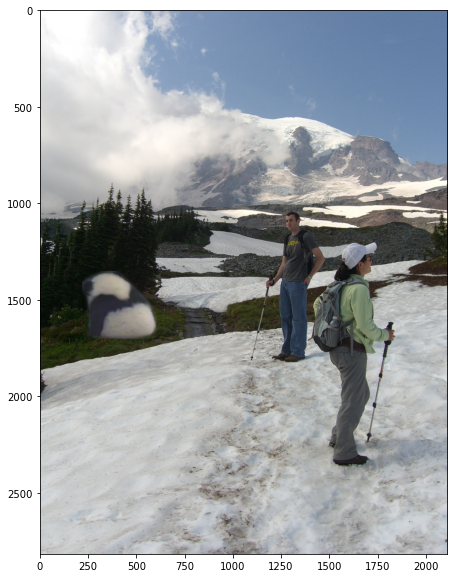

In [28]:
plt.figure("Object Image", figsize=(5,5))
plt.imshow(object_img)
plt.show()

plt.figure("Background Image", figsize=(5,5))
plt.imshow(background_img)
plt.show()

lap_img = np.zeros(background_img.shape)
for i in range(0, 3):
    lap_img[:,:,i] = laplacian_blend(object_img[:,:,i], np.float32(object_mask), background_img[:,:,i].copy(), bg_ul)

plt.figure("Laplacian Pyramid Blending", figsize=(10,10))
plt.imshow(lap_img)